<a href="https://colab.research.google.com/github/antonercool/deep-learning-exam-project/blob/master/FallDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning course project - Fall Detection




###Group members


*   Anton Sihm, studentId.: 201504954
*   Peter Marcus Hoveling, studentId.: 201508876







###Purpose

This project aims to detect human actions from live video feed, in order to achieve safety, such as
alarms when elderly people fall in their apartments.








---



### Data sets

To evaluate the fall detection, dataset from realistic video surveillance settings will be used. Framerate
and resolution may vary as finding the same formatted video data is challenging


*   mViA - Fall detection dataset



## Task 0: Mounting Google Drive data


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Creating a variable to the specific files mouted

In [ ]:
from pathlib import Path
root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'Data_complete' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/Data"

Validating the data directory

In [ ]:
print(p)

/content/gdrive/My Drive/Data_complete


## Task 1: Preprocessing

## Utils

In [ ]:
# Importing all necessary libraries
import cv2
import os
import numpy 
import random

class VideoUtils:

  def __init__(self):
    pass

  def convert_single_video_to_images(self, video_path, annotation_path, dim):
    # Read the video from specified path
    video = cv2.VideoCapture(video_path)
    meta_data = open(annotation_path)

    start_fall_frame = meta_data.readline() 
    end_fall_frame = meta_data.readline() 

    not_falling = False
    # check if has labels
    if "," in start_fall_frame:
      #print(f"does not contain : {annotation_path}")
      ## skip current
      not_falling = True
      start_fall_frame = 0
      end_fall_frame = 0
    else:
      start_fall_frame = int(start_fall_frame)
      end_fall_frame = int(end_fall_frame)  

    traning_samples = []
    training_labels = []

    currentframe = 0

    while(True):

      # reading from frame
      ret,frame = video.read()
      if ret:
        if(frame.shape[0] != dim[0] or frame.shape[1] != dim[1]):
          try:
            frame = self.center_crop(frame, dim)
          except e:
            print(f"failed to center from image from vid : {video_path}, error {e}")

        traning_samples.append(frame)

        if not_falling == False:
          # if falling - label 1
          if currentframe >= start_fall_frame and currentframe <= end_fall_frame:
            training_labels.append(1)
          # not falling - label 0
          else:
            training_labels.append(0)
        else:
          training_labels.append(0)

        # increasing counter so that it will
        # show how many frames are created
        currentframe += 1
      else:
        break

    # Release all space and windows once done
    video.release()
    cv2.destroyAllWindows()

    traning_samples = numpy.array(traning_samples)
    training_labels =  numpy.array(training_labels)

    return (traning_samples, training_labels, True)

  # Function from: https://medium.com/curious-manava/center-crop-and-scaling-in-opencv-using-python-279c1bb77c74
  def center_crop(self, img, dim):
	  """Returns center cropped image
	  Args:
	  img: image to be center cropped
	  dim: dimensions (width, height) to be cropped
	  """
	  width, height = img.shape[1], img.shape[0]

	  # process crop width and height for max available dimension
	  crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	  crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	  mid_x, mid_y = int(width/2), int(height/2)
	  cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	  crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	  return crop_img


  def _get_movie_IDs(self, root_path):
    list_video_paths = []
    annotation_path = r"/Annotation_files"
    video_path = r"/Videos"
    
    data_sub_dir = os.listdir(root_path)

    # interate each sub dir
    for dir in data_sub_dir:
      if ".ipynb" in dir:
        continue
      if "model" in data_sub_dir:
        continue  
      # for each file in sub dir
      for file in os.listdir(str(root_path) + "/" + dir + video_path):
        absolute_video_file_path = str(str(root_path) + "/" + dir + video_path + "/"+ file)
        list_video_paths.append(absolute_video_file_path)

    return list_video_paths


  def normalize_image(self, image):
    # normalizing values between 0 - 1
    return image/255.0

  # create_partition_list(p)
  def create_partition_list(self, root_path, traning_percentage=80, validation_percentage=20):
    partition = {}

    absolute_video_path_list = video_utils._get_movie_IDs(root_path)
    random.shuffle(absolute_video_path_list)

    to_index = int((len(absolute_video_path_list)+1)*(traning_percentage/100))
    from_index = int(len(absolute_video_path_list)*(traning_percentage/100)+1)

    print(f"traning {0}:{to_index}")
    print(f"validation {from_index}:{len(absolute_video_path_list)}")

    training = absolute_video_path_list[0:to_index]
    validation = absolute_video_path_list[from_index:]

    total_frames_training = 0
    total_frames_validation = 0
    
    for image_path in training:
      cap= cv2.VideoCapture(image_path)
      total_frames_training += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for image_path in validation:
      cap= cv2.VideoCapture(image_path)
      total_frames_validation += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    partition['Training'] = (training, total_frames_training)
    partition['Validation'] = (validation, total_frames_validation)

    return partition

### Testing Video ultils


In [ ]:
video_utils = VideoUtils()
traning_samples, training_labels, is_ok = video_utils.convert_single_video_to_images(str(p) + "/Office/Videos/video (6).avi", str(p) + "/Office/Annotation_files/video (6).txt", (180,180))
print(traning_samples.shape)

absolute_video_path_list = video_utils._get_movie_IDs(p)

partition = video_utils.create_partition_list(p)

print(partition['Training'][1])
print(partition['Validation'][1])


(415, 180, 180, 3)
traning 0:0
validation 1:0
0
0


### Dataloader

In [ ]:
import numpy as np
import keras
from tensorflow.keras.utils import Sequence
from keras import utils as np_utils
import random

class FallingDataGenerator(Sequence):

  def __init__(self, movie_path_list, total_movie_frames, batch_size=32, dim=(240, 320), n_channels=3, n_classes=2, shuffle=True): 
      'Initialization'
      self.dim = dim
      self.batch_size = batch_size
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.movie_path_list = movie_path_list
      self.total_movie_frames = total_movie_frames
      self.current_video_data = 0# ((415, 240, 320, 3)(415)) # 0-32, 32-64 ...... 400-415    
      self.current_video_frame = 0
      self.current_movie_index = 0
      self.video_utils = VideoUtils()
      self.current_batch = 0

      # init by shuffle
      self.on_epoch_end()

  # Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike
  ## TODO shuffle path list
  def on_epoch_end(self):
    'Updates indexes after each epoch'
    print("DEBUG - on epoch end")
    random.shuffle(self.movie_path_list)
    self.current_video_data = 0
    self.current_video_frame = 0
    self.current_movie_index = 0


  def __data_generation(self):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.zeros((self.batch_size, *self.dim, self.n_channels)) # (32, H, W, 3)
    Y = np.zeros((self.batch_size), dtype=int)

    ## Init - first time load
    if(self.current_video_data == 0 and self.current_video_frame == 0 and self.current_movie_index == 0):
      #####print("DEBUG - First time load")
      video_path = self.movie_path_list[self.current_movie_index]
      annotation_path = video_path.replace("Videos", "Annotation_files")
      annotation_path = annotation_path.replace(".avi", ".txt")

      self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
      self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
    
    total_number_of_current_images = len(self.current_video_data[0])
    #####print(f"DEBUG - total_number_of_current_images : {total_number_of_current_images}")

    # Check if dont have enough frames
    if(self.current_video_frame + self.batch_size + 1 > total_number_of_current_images):
      #####print(f"DEBUG - not have enough frames{self.current_video_frame + self.batch_size -1}>{total_number_of_current_images} - taking from current and current + 1")
      # How many frames did we overextend with
      residual_value_from_current_video = (self.current_video_frame + self.batch_size)%total_number_of_current_images
      # How many frames are we missing to complete current video
      frames_missing = self.batch_size - residual_value_from_current_video

      # loop for the remaining needed frames
      for i in range(frames_missing):
        #####print(f"DEBUG - taking frame_index: {self.current_video_frame}")
        X[i,] = self.current_video_data[0][self.current_video_frame]
        Y[i,] = self.current_video_data[1][self.current_video_frame]
        self.current_video_frame += 1
    
      # Continue to next video
      self.current_movie_index += 1
      self.current_video_frame = 0
      self.current_video_data = 0

      # If we have more movies
      # 0, 1, 2     -- 2<=2
      if(self.current_movie_index <= (len(self.movie_path_list) - 1)):
        #####print("DEBUG - taking new vid")
        video_path = self.movie_path_list[self.current_movie_index]
        annotation_path = video_path.replace("Videos", "Annotation_files")
        annotation_path = annotation_path.replace(".avi", ".txt")

        self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
        self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
        for i in range(frames_missing, self.batch_size):
          X[i,] = self.current_video_data[0][self.current_video_frame]
          Y[i,] = self.current_video_data[1][self.current_video_frame]
          self.current_video_frame += 1
        
    # We do have enough frames
    else:
      #####print("DEBUG - We have frames - taking from current only")
      for i in range(self.batch_size):
        X[i,] = self.current_video_data[0][self.current_video_frame]
        Y[i,] = self.current_video_data[1][self.current_video_frame]
        self.current_video_frame += 1
      
      # If we have an exact match of video frames and have more videos
      #####print(f"DEBUG {self.current_video_frame} == {total_number_of_current_images} and {self.current_movie_index} <= {(len(self.movie_path_list) - 1)}")
      if(self.current_video_frame == total_number_of_current_images and self.current_movie_index <= (len(self.movie_path_list) - 1)):
        #####print(f"DEBUG - having exact match")
        # Continue to next video
        self.current_movie_index += 1
        self.current_video_frame = 0

        video_path = self.movie_path_list[self.current_movie_index]
        annotation_path = video_path.replace("Videos", "Annotation_files")
        annotation_path = annotation_path.replace(".avi", ".txt")

        self.current_video_data = self.video_utils.convert_single_video_to_images(video_path, annotation_path, self.dim)
        self.current_video_data = (self.video_utils.normalize_image(self.current_video_data[0]), self.current_video_data[1])
    
    return X, keras.utils.np_utils.to_categorical(Y, num_classes=self.n_classes)

  def __len__(self):
    'Denotes the number of batches per epoch'
    ## Total number of frames in all videos / batchsize
    return int(np.floor(self.total_movie_frames / self.batch_size) - 10)


  def __getitem__(self, index):
    'Generate one batch of data'
    
    if(self.current_batch > self.__len__()-1):
      self.on_epoch_end()

    # Generate data
    X, y = self.__data_generation()
    
    return X, y


### Testing data loader


In [ ]:
#utils_video
video_utils = VideoUtils()

# Datasets
partition = video_utils.create_partition_list(p)

traning 0:0
validation 1:0


In [ ]:
# Parameters
params = {'batch_size': 32,
          'dim': (180,180),
          'n_channels': 3,
          'n_classes': 2, 
          'shuffle': True}

# Generators
#short = partition['Training'][0][0:3]
training_generator = FallingDataGenerator(partition['Training'][0], partition['Training'][1], **params)
validation_generator = FallingDataGenerator(partition['Validation'][0], partition['Validation'][1], **params)

DEBUG - on epoch end
DEBUG - on epoch end


In [ ]:
x,y = training_generator.__getitem__()
print(f"current movie file index : {training_generator.current_movie_index}")
print(f"current video frame in movie: {training_generator.current_video_frame}")
print(f"batch : {len(x)}")

### Model Training



In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten

# Model
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256)) # W1*x + b
model.add(Activation('relu')) # ReLU(W1*x + b)
model.add(Dropout(0.5))
model.add(Dense(2)) # number of classes
model.add(Activation('softmax'))  # softmax(W2*x + b)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 180, 180, 8)       224       
                                                                 
 activation_6 (Activation)   (None, 180, 180, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 16)        1168      
                                                                 
 activation_7 (Activation)   (None, 88, 88, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 44, 44, 16)       0         
 2D)                                                  

### Model fit - takes around 20 mins


In [ ]:
# Compile the model before training
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = 2

history = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=number_of_epochs, use_multiprocessing=False)
model.save(str(p)+ "/model")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/2
1813/1813 [==============================] - 599s 313ms/step - loss: 0.2224 - accuracy: 0.9462 - val_loss: 0.2027 - val_accuracy: 0.9491
DEBUG - on epoch end
Epoch 2/2
1813/1813 [==============================] - 537s 295ms/step - loss: 0.2099 - accuracy: 0.9462 - val_loss: 0.1954 - val_accuracy: 0.9520
DEBUG - on epoch end
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Data_complete/model/assets


### Evalutate - 1 vid

In [ ]:
video_path = str(p) + "/Coffee_room_01/Videos/video (5).avi"
annotation_path = str(p) + "/Coffee_room_01/Annotation_files/video (5).txt"
dim = (180, 180)
video_utils = VideoUtils()

current_video_data = video_utils.convert_single_video_to_images(video_path, annotation_path, dim)
current_video_data = (video_utils.normalize_image(current_video_data[0]), current_video_data[1])

test_predictions = model.predict(current_video_data[0])
#print(test_predictions[0])

#for i, prediction in enumerate(test_predictions):
#  print(prediction)
#  print(f"Current video data: {current_video_data[1][i]}")


#test_acc, test_loss = model.evaluate(current_video_data[0], current_video_data[1], verbose=2)
#print(test_acc)
#print(test_loss)


### Dataset review

### Falling vs. not-falling class distribution - 9 mins to run

In [ ]:
video_utils = VideoUtils()

# Falling vs. not-falling class distribution       //9 mins to run
total_movies_to_fetch = video_utils._get_movie_IDs(p)

print(f"Total movies: {len(total_movies_to_fetch)}")
label_0_count = 0
label_1_count = 0


for movie in total_movies_to_fetch:
  annotation_path = movie.replace("Videos", "Annotation_files")
  annotation_path = annotation_path.replace(".avi", ".txt")

  samples, labels, _ = video_utils.convert_single_video_to_images(movie, annotation_path, (180, 180))

  label_0_count += labels.tolist().count(0)
  label_1_count += labels.tolist().count(1)

print(f"Total number of 'Not-Falling' samples: {label_0_count}")
print(f"Total number of 'Falling' samples: {label_1_count}")
print(f"{(label_1_count/(label_1_count + label_0_count))*100}% is falling")

Total movies: 190
Total number of 'Not-Falling' samples: 71883
Total number of 'Falling' samples: 4028
Falling dataset %: 5.306213855699438%


### confusion matrix


In [ ]:
model = keras.models.load_model(str(p) + "/model")


test_paths  = partition['Validation'][0]

true_labels = []
predicted_labels = []

for test_path in test_paths:
  annotation_path = test_path.replace("Videos", "Annotation_files")
  annotation_path = annotation_path.replace(".avi", ".txt")
  samples, current_vid_labels, _ = video_utils.convert_single_video_to_images(test_path, annotation_path, (180, 180))
  samples = video_utils.normalize_image(samples)
  probabilities = model.predict(samples)
  current_vid_predictions = np.argmax(probabilities,axis=1)

  for i in range(len(current_vid_labels)):
    true_labels.append(current_vid_labels[i])
    predicted_labels.append(current_vid_predictions[i])

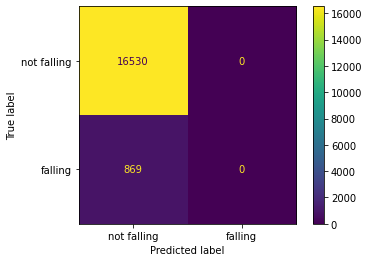

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matix  = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matix,
                              display_labels=["not falling", "falling"])
disp.plot()

plt.show()

The confusion matrix shows that the model predicts "not falling 100%" and allways confuses falling as "not falling"
* Total number of 'Not-Falling' samples: 71883
* Total number of 'Falling' samples: 4028
*  5.306213855699438 % of the data is falling 

Very imbalanced

### TODO
* **Search about class imbalance**
  * Binary classifier, where we can edit wiegted loss W_1*l0 + W_2*l1 where W_2 counts for more since, we dont have that much falling data
* **Modify own datagenereator**
  * Oversampling/undersampling
  * Oversampling: **bold text** Instead of taking next 32 frames, we should take 16,16 of each class(falling/not falling) and oversampling from the falling distribution, since we dont have that many
  * **Data augmentation**:
  * Augment the falling distribution since we dont have that many samples
* **Look into what crossvalidation is**